In [ ]:
!pip install pyDOE
!pip install plotting
!pip install scipy==1.2 --upgrade
!pip install -U -q scipy
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
from pyDOE import lhs
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from google.colab import files
import matplotlib.ticker as ticker

!wget https://github.com/maziarraissi/PINNs/blob/master/appendix/Data/burgers_shock.mat?raw=true
!mv burgers_shock.mat\?raw\=true burgers_shock.mat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=426b2454fc07e4972535fc57a80c42f1a57dfc2d0db63cce5215d00a944b7eed
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.6 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.3.8 requires scipy>=1.2.1, but you h

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import grad
import torch.optim as optim
torch.set_default_dtype(torch.float32)
import random

np.random.seed(1234)
torch.manual_seed(1234)
random.seed(1234)

In [ ]:
data_sol = io.loadmat('burgers_shock.mat')

lb_sol = np.array([0.0, -1.0])
ub_sol = np.array([1.0, 1.0]) 

t_sol = data_sol['t'].flatten()[:,None]
x_sol = data_sol['x'].flatten()[:,None]
Exact_sol = np.real(data_sol['usol'])

T_sol, X_sol = np.meshgrid(t_sol,x_sol)

t_sol_star = T_sol.flatten()[:,None]
x_sol_star = X_sol.flatten()[:,None]
X_sol_star = np.hstack((t_sol_star, x_sol_star))
u_sol_star = Exact_sol.flatten()[:,None]

N0 = Exact_sol.shape[0]
N_b = Exact_sol.shape[1]

N_f = 10000
#N_f = 20000
    
idx_x = np.random.choice(x_sol.shape[0], N0, replace=False)
x0_train = x_sol[idx_x,:]
u0_train = Exact_sol[idx_x,0:1]

idx_t = np.random.choice(t_sol.shape[0], N_b, replace=False)
tb_train = t_sol[idx_t,:]

X_f_train = lb_sol + (ub_sol-lb_sol)*lhs(2, N_f)

#pinn_layers = [2, 50, 50, 50, 50, 1]
x0_train = x0_train[0:160, :]
u0_train = u0_train[0:160, :]
tb_train = tb_train[0:40, :]

In [ ]:
# Training Data for Solution
## Generate points from initial condition x0
## x0: 256*1, just perturbed grid data from -8 to 8
X0 = np.concatenate((0*x0_train, x0_train), 1) # (0, x0)

## tb: 201*1, just perturbed grid data from 0 to 10
## Generate points from lower boundary condition, (tb, -8)
X_lb = np.concatenate((tb_train, 0*tb_train + lb_sol[1]), 1) # (tb, lb[1])


## Generate points from upper boundary condition, (tb, 8)
X_ub = np.concatenate((tb_train, 0*tb_train + ub_sol[1]), 1) # (tb, ub[1])


## 20000*2 X_f seems like randomly generated points (t, x) in 
## the range [0,10]*[-8,8]
#X_f = X_f # Collocation Points


## 256*1, In this case, they are all zeros
## So a column vector of size 256, elements are zeros
t0 = X0[:, 0:1] # Initial Data (time)

## this is just x0 again
## i.e a column vector of a perturbed x grid data from -1 to 1
x0 = X0[:, 1:2] # Initial Data (space)

## 100*1, this is just tb again
## i.e a column vector of a perturbed t grid data from 0 to 10
t_lb = X_lb[:, 0:1] # Boundary Data (time) -- lower boundary

## a column vector of size 201, elements are all -1    
x_lb = X_lb[:, 1:2] # Boundary Data (space) -- lower boundary

## 100*1, this is just tb again
## i.e a column vector of a perturbed t grid data from 0 to 10
t_ub = X_ub[:, 0:1] # Boundary Data (time) -- upper boundary

## a column vector of size 201, elements are all 1  
x_ub = X_ub[:, 1:2] # Boundary Data (space) -- upper boundary

## 20000*1 randomly generated time data in [0,10]
t_f = X_f_train[:, 0:1] # Collocation Points (time)

## 20000*1 randomly generated spce data in [-8,8]
x_f = X_f_train[:, 1:2] # Collocation Points (space)

## 256*1, u0 the actual initial value u(0, x)
## perturbed the same way as the x grid data x0
u0 = u0_train # Boundary Data


x0_train = torch.from_numpy(x0_train).type(torch.float)
u0_train = torch.from_numpy(u0_train).type(torch.float)
tb_train = torch.from_numpy(tb_train).type(torch.float)
X_f_train = torch.from_numpy(X_f_train).type(torch.float)
lb_sol = torch.from_numpy(lb_sol).type(torch.float)
ub_sol = torch.from_numpy(ub_sol).type(torch.float)

X0 = torch.from_numpy(X0).type(torch.float)
X_lb = torch.from_numpy(X_lb).type(torch.float)
X_ub = torch.from_numpy(X_ub).type(torch.float)

x0 = torch.from_numpy(x0).type(torch.float)
t0 = torch.from_numpy(t0).type(torch.float)

t_f = torch.from_numpy(t_f).type(torch.float)
x_f = torch.from_numpy(x_f).type(torch.float)
u0 = torch.from_numpy(u0).type(torch.float)

x_lb = torch.from_numpy(x_lb).type(torch.float)
x_ub = torch.from_numpy(x_ub).type(torch.float)
t_lb = torch.from_numpy(t_lb).type(torch.float)
t_ub = torch.from_numpy(t_ub).type(torch.float)

tb_train.requires_grad = True
x0_train.requires_grad = True
u0_train.requires_grad = True
X_f_train.requires_grad = True

x_lb.requires_grad = True
x_ub.requires_grad = True

t_f.requires_grad = True
x_f.requires_grad = True


In [ ]:
class Custom_sin(nn.Module):
    def __init__(self):
        super(Custom_sin, self).__init__()

    def forward(self, input):
        return torch.sin(input)

class PINN(nn.Module):
  def __init__(self, x0, u0, tb, X_f, layers, lb_sol, ub_sol, activation_fun=Custom_sin):
    super(PINN, self).__init__()

    self.lb_sol = lb_sol
    self.ub_sol = ub_sol

    self.act_fun = activation_fun()

    self.hidden_layers = [nn.Linear(layers[0], layers[1])]
    for idx, width in enumerate(layers[1:-1]):
      if idx < (len(layers[1:-1]) - 1):
        self.hidden_layers.append(nn.Linear(width, layers[idx + 2]))

    self.output_layer = nn.Linear(layers[-2], layers[-1]) 
   
    self.fnn = self.layers()
    

  def forward(self, t, x):
      X = torch.cat([t,x], 1)
      ## rescale the grid data from [0,10]*[-8,8] to [0,1]*[-1,1]
      H = 2.0 * (X - self.lb_sol)/(self.ub_sol - self.lb_sol) - 1.0

      output = self.fnn(H)
      return output

  def layers(self):
      modules = []
      for idx, layer in enumerate(self.hidden_layers):
          modules.append(layer)
          modules.append(self.act_fun)
      modules.append(self.output_layer)

      return nn.Sequential(*modules)

In [ ]:
# takes in a module and applies the specified weight initialization
def weights_init_xavier_rule(m):
  classname = m.__class__.__name__
  # for every Linear layer in a model..
  if classname.find('Linear') != -1:
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0)


In [ ]:
pinn_layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
pinn = PINN(x0_train, u0_train, tb_train, X_f_train, pinn_layers, lb_sol, ub_sol, Custom_sin)
pinn.apply(weights_init_xavier_rule)

PINN(
  (act_fun): Custom_sin()
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
  (fnn): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Custom_sin()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Custom_sin()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Custom_sin()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Custom_sin()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Custom_sin()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Custom_sin()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Custom_sin()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Custom_sin()
    (16): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.LBFGS(pinn.parameters(), lr=0.01, max_iter=1, max_eval=1)
                  
from datetime import datetime
time = datetime.now()
epoch    = 10000
pinn_loss_hist = []
t_sol_star2=  torch.from_numpy(t_sol_star).type(torch.float)
x_sol_star2= torch.from_numpy(x_sol_star).type(torch.float)
pinn_pred_hist = [[]]
for e in range(epoch):
    
    # update the parameters
    def closure():
      # clear the gradients
      optimizer.zero_grad()
      
      # compute the loss function
      lb_pred = pinn.forward(t_lb, x_lb)
      ub_pred = pinn.forward(t_ub, x_ub)
      # u_x_lb_pred = torch.autograd.grad(lb_pred, x_lb, torch.ones_like(lb_pred), create_graph=True)[0]
      # u_x_ub_pred = torch.autograd.grad(ub_pred, x_ub, torch.ones_like(ub_pred), create_graph=True)[0]

      pred_u = pinn.forward(t_f, x_f)
      pred_u_t = torch.autograd.grad(pred_u, t_f, torch.ones_like(pred_u), create_graph=True)[0]
      pred_u_x = torch.autograd.grad(pred_u, x_f, torch.ones_like(pred_u), create_graph=True)[0]
      pred_u_xx = torch.autograd.grad(pred_u_x, x_f, torch.ones_like(pred_u_x), create_graph=True)[0]
      N_pred = -pred_u*pred_u_x+(0.01/torch.pi)*pred_u_xx

      MSE_0 = torch.mean(torch.square(u0-pinn.forward(t0,x0)))
      MSE_b_u = torch.mean(torch.square(lb_pred-ub_pred))
      # MSE_b_ux = torch.mean(torch.square(u_x_lb_pred-u_x_ub_pred))
      MSE_f = torch.mean(torch.square(pred_u_t-N_pred)) #

      # loss = MSE_0 + MSE_b_u + MSE_b_ux + MSE_f
      loss = MSE_0 + MSE_b_u + MSE_f

      # compute the gradient of the model parameters
      loss.backward(retain_graph=True)   ## "each successive batch will take more time than 
      #print("epoch=",e," loss=",loss.item())
      return loss
    optimizer.step(closure)
    
    pinn_loss_hist.append(closure().item())

    if e <= 500:
      if e % 20 == 0: 
        print("epoch = %6d" % e, end="")
        print("  epoch loss = %10.8f" % closure().item(), end="")
        print("  time: {}".format(datetime.now() - time), end="")
        u_pred = pinn.forward(t_sol_star2, x_sol_star2)
        u_pred = u_pred.detach().numpy()
        print(" Relative L2-error = ", np.linalg.norm(u_sol_star - u_pred, 2) / np.linalg.norm(u_sol_star, 2))
        print("\n")
        pinn_hat = pinn.forward(t_sol_star2, x_sol_star2)
        pinn_pred_hist.append(pinn_hat)

    else:
      if e % 200 == 0:
        print("epoch = %6d" % e, end="")
        print("  epoch loss = %10.8f" % closure().item(), end="")
        print("  time: {}".format(datetime.now() - time), end="")
        u_pred = pinn.forward(t_sol_star2, x_sol_star2)
        u_pred = u_pred.detach().numpy()
        print(" Relative L2-error = ", np.linalg.norm(u_sol_star - u_pred, 2) / np.linalg.norm(u_sol_star, 2))
        print("\n")
        pinn_hat = pinn.forward(t_sol_star2, x_sol_star2)
        pinn_pred_hist.append(pinn_hat)


epoch =      0  epoch loss = 0.70321774  time: 0:00:00.693316 Relative L2-error =  0.9455952422963277


epoch =     20  epoch loss = 0.57348543  time: 0:00:07.168205 Relative L2-error =  0.9430044198211183


epoch =     40  epoch loss = 0.51228344  time: 0:00:13.734839 Relative L2-error =  0.9452365758449297


epoch =     60  epoch loss = 0.48643464  time: 0:00:21.756150 Relative L2-error =  0.947059658025835


epoch =     80  epoch loss = 0.46938261  time: 0:00:28.780204 Relative L2-error =  0.9477244617552798


epoch =    100  epoch loss = 0.45473662  time: 0:00:35.892469 Relative L2-error =  0.9466335697583876


epoch =    120  epoch loss = 0.43624854  time: 0:00:42.854609 Relative L2-error =  0.9409838289110374


epoch =    140  epoch loss = 0.38631362  time: 0:00:49.770721 Relative L2-error =  0.904967501829531


epoch =    160  epoch loss = 0.32693982  time: 0:00:56.592211 Relative L2-error =  0.837363082184148


epoch =    180  epoch loss = 0.28452721  time: 0:01:03.435689 Relat

KeyboardInterrupt: ignored

In [ ]:
torch.save(pinn.state_dict(),"PiNNsingle8_20_Loss1e-05_Err3e-3.pth")

In [ ]:
pinn.load_state_dict(torch.load("PiNNsingle8_20_Loss1e-05_Err3e-3.pth"))
pinn.eval()

In [ ]:
epochs=np.append(np.linspace(0,500,26, dtype=int),np.linspace(600,5200,24,dtype=int))

In [ ]:
files1 = []
for i in range(1,51):
  u_pred=pinn_pred_hist[i].detach().numpy()
  U_pred = griddata(X_sol_star, u_pred.flatten(), (T_sol, X_sol), method='cubic')

  fig, ax = plt.subplots()
  h = ax.imshow(U_pred, interpolation='nearest', cmap='jet', 
                #extent=[lb_idn[0], ub_idn[0], lb_idn[1], ub_idn[1]],
                extent=[0,1,-1,1],
                origin='lower', aspect='auto', vmin=-1.1, vmax=1.1)

  cbar = fig.colorbar(h) #, format=ticker.FuncFormatter(fmt)
  ax.text(1.3, 0.3, "Epochs: %i"%(epochs[i-1]), fontsize="x-large", color="k")
  ax.text(1.3, 0, "Loss: {:.2e}".format(pinn_loss_hist[epochs[i-1]]), fontsize="x-large", color="k")
  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  ax.set_title('Predictions', fontsize = "x-large")
  
  file = "2dplots/pred_%.8i.png"%(i)
  plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  files1.append(file)

In [ ]:
u_pred=pinn_pred_hist[50].detach().numpy()
U_pred = griddata(X_sol_star, u_pred.flatten(), (T_sol, X_sol), method='cubic')
pinn_error = abs(U_pred - Exact_sol)
print(np.max(np.log(pinn_error)))
print(np.min(np.log(pinn_error)))
print(np.mean(np.log(pinn_error)))

-2.912568736970712
-17.778677507942263
-8.208942742815449


In [ ]:
files2 = []
for i in range(1,51):
  u_pred=pinn_pred_hist[i].detach().numpy()
  U_pred = griddata(X_sol_star, u_pred.flatten(), (T_sol, X_sol), method='cubic')
  pinn_error = abs(U_pred - Exact_sol)

  fig, ax = plt.subplots()
  h = ax.imshow(np.log(pinn_error), interpolation='nearest', cmap='jet', 
                extent=[0,1,-1,1],
                origin='lower', aspect='auto', vmin=-16, vmax=0.1)

  cbar = fig.colorbar(h) #, format=ticker.FuncFormatter(fmt)
  ax.text(1.3, 0.3, "Epochs: %i"%(epochs[i-1]), fontsize="x-large", color="k")
  ax.text(1.3, 0, "Loss: {:.2e}".format(pinn_loss_hist[epochs[i-1]]), fontsize="x-large", color="k")
  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  ax.set_title('Predictions', fontsize = "x-large")
  
  file = "2derror/error_%.8i.png"%(i)
  plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  files2.append(file)

In [ ]:
from PIL import Image
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


In [ ]:
save_gif("pinn_pred.gif", files1, fps=8, loop=0)

In [ ]:
save_gif("pinn_error.gif", files2, fps=8, loop=0)

In [ ]:
u_pred=pinn.forward(t_sol_star2, x_sol_star2)
u_pred=u_pred.detach().numpy()
U_pred=griddata(X_sol_star, u_pred.flatten(), (T_sol, X_sol), method='cubic')
pinn_error=U_pred - Exact_sol

files3 = []
for i in range(0,100):
  plt.figure()
  plt.plot(X_sol[:,1],Exact_sol[:,i],linewidth=4,color='b',label="Exact")
  plt.plot(X_sol[:,1],U_pred[:,i],'--',color='r',linewidth=4,label="Predicted")
  plt.legend(loc="upper right",fontsize="large")
  plt.ylim(-1.1, 1.1)
  plt.xlabel('$x$',fontsize="large")
  plt.ylabel('$u(t,x)$',fontsize="large")
  plt.title('Time t = {:.2f}'.format(float(t_sol[i])), fontsize = "x-large")
  
  file = "predtime/predtime_%.8i.png"%(i)
  plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  files3.append(file)



In [ ]:
pinn_error=U_pred - Exact_sol
files4 = []
for i in range(0,100):
  plt.figure()
  plt.plot(X_sol[:,-1],pinn_error[:,i],linewidth=3)
  
  plt.ylim(-0.003,0.04)
  plt.xlabel('$x$',fontsize="large")
  plt.ylabel('Error',fontsize="large")
  plt.title('Time t = {:.2f}'.format(float(t_sol[i])), fontsize = "x-large")
  
  file = "predtime/predtime_%.8i.png"%(i)
  plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  files4.append(file)


In [ ]:
files5 = []
for i in range(1,101):
  fig, ax = plt.subplots()
  h = ax.imshow(Exact_sol[:,0:i], interpolation='nearest', cmap='jet', 
                #extent=[lb_idn[0], ub_idn[0], lb_idn[1], ub_idn[1]],
                extent=[0,0.01*i,-1,1],
                origin='lower', aspect='auto', vmin=-1.1, vmax=1.1)

  cbar = fig.colorbar(h) #, format=ticker.FuncFormatter(fmt)
  ax.axis(xmin=0.0,xmax=1)
  ax.set_xlabel('$t$')
  ax.set_ylabel('$x$')
  ax.set_title('Exact Solution', fontsize = "x-large")
  
  file = "2dsol/exactsol_%.8i.png"%(i)
  plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  files5.append(file)

In [ ]:
files6 = []
for i in range(0,100):
  plt.figure()
  plt.plot(Exact_sol[:,i],linewidth=3)
  
  plt.ylim(-1.1,1.1)
  plt.xlabel('$x$',fontsize="large")
  plt.ylabel('$u(t,x)$',fontsize="large")
  plt.title('Time t = {:.2f}'.format(float(t_sol[i])), fontsize = "x-large")
  
  file = "2dsoltime/exactsoltime_%.8i.png"%(i)
  plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
  files6.append(file)

In [ ]:
save_gif("pinn_predtime.gif", files3, fps=16, loop=0)

In [ ]:
save_gif("pinn_errortime.gif", files4, fps=16, loop=0)

In [ ]:
save_gif("exact_sol_2d.gif", files5, fps=5, loop=0)

In [ ]:
save_gif("exact_sol_time.gif", files6, fps=5, loop=0)

Text(0.5, 1.0, 'Time t = 0.01')

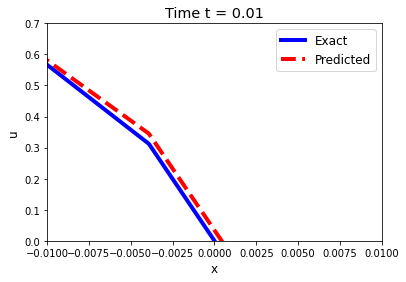

In [ ]:
pinn_error=U_pred - Exact_sol
plt.plot()
# plt.plot(X_sol[:,-1],pinn_error[:,1],linewidth=4)
plt.plot(X_sol[:,1],Exact_sol[:,99],linewidth=4,color='b',label="Exact")
plt.plot(X_sol[:,1],U_pred[:,99],'--',color='r',linewidth=4,label="Predicted")
plt.legend(loc="upper right",fontsize="large")
plt.ylim(0.0,0.7)
plt.xlim(-0.01,0.01)
plt.xlabel("x",fontsize="large")
plt.ylabel("u",fontsize="large")
plt.title('Time t = {:.2f}'.format(float(t_sol[1])), fontsize = "x-large")

Text(0.5, 1.0, 'Predictions')

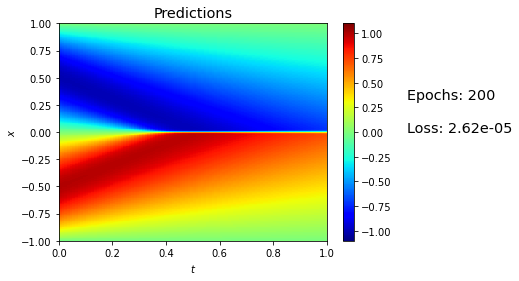

In [ ]:
datapred = pinn_pred_hist[50].detach().numpy()
U_pred = griddata(X_sol_star, datapred.flatten(), (T_sol, X_sol), method='cubic')
fig, ax = plt.subplots()
h = ax.imshow(U_pred, interpolation='nearest', cmap='jet', 
              #extent=[lb_idn[0], ub_idn[0], lb_idn[1], ub_idn[1]],
              extent=[0,1,-1,1],
              origin='lower', aspect='auto', vmin=-1.1, vmax=1.1)

cbar = fig.colorbar(h) #, format=ticker.FuncFormatter(fmt)
ax.text(1.3, 0.3, "Epochs: %i"%(200), fontsize="x-large", color="k")
ax.text(1.3, 0, "Loss: {:.2e}".format(pinn_loss_hist[5000]), fontsize="x-large", color="k")
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Predictions', fontsize = "x-large")

In [ ]:
torch.save(pinn_pred_hist,"pinnSingle_pred_hist.pth")

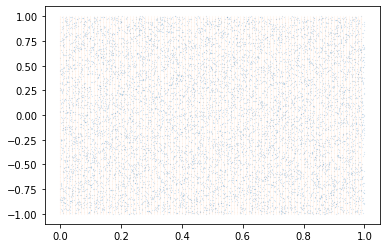

In [ ]:
datatry = lb_sol + (ub_sol-lb_sol)*lhs(2, N_f)
plt.scatter(datatry[:,0:1],datatry[:,1:2],0.003)
plt.scatter(t_sol_star,x_sol_star,0.0003)

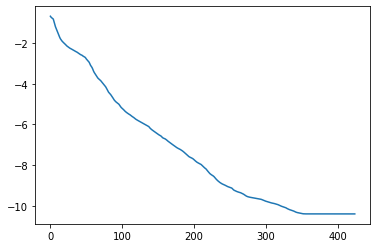

In [ ]:
plt.plot(np.log(pinn_loss_hist))

In [ ]:
t_sol_star1=  torch.from_numpy(t_sol_star).type(torch.DoubleTensor)
x_sol_star1= torch.from_numpy(x_sol_star).type(torch.DoubleTensor)
u_pred = pinn.forward(t_sol_star1, x_sol_star1)
u_pred = u_pred.detach().numpy()
print(np.linalg.norm(u_sol_star-u_pred,2)/np.linalg.norm(u_sol_star,2))

0.0027822886452921855


In [ ]:
t_int = data_sol['t'].flatten()[1:,None]
x_int = data_sol['x'].flatten()[1:-1:,None]
T_int, X_int = np.meshgrid(t_int,x_int)
Exact_sol = np.real(data_sol['usol'])
Exact_int = Exact_sol[1:-1,:]
Exact_int = Exact_int[:,1:]

t_int_star = T_int.flatten()[:,None]
x_int_star = X_int.flatten()[:,None]
X_int_star = np.hstack((t_int_star, x_int_star))
u_int_star = Exact_int.flatten()[:,None]

t_int_star1=  torch.from_numpy(t_int_star).type(torch.DoubleTensor)
x_int_star1= torch.from_numpy(x_int_star).type(torch.DoubleTensor)
u_pred_int = pinn.forward(t_int_star1, x_int_star1)
u_pred_int = u_pred_int.detach().numpy()  
error_u_int = np.linalg.norm(u_int_star-u_pred_int,2)/np.linalg.norm(u_int_star,2)
print('Error u: %e' % (error_u_int))



Error u: 2.784417e-03


Text(0.5, 1.0, 'Learned Dynamics')

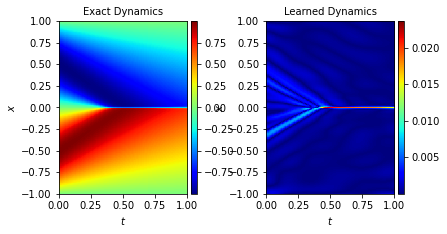

In [ ]:
# t_sol_star1=  torch.from_numpy(t_sol_star).type(torch.DoubleTensor)
# x_sol_star1= torch.from_numpy(x_sol_star).type(torch.DoubleTensor)
# u_pred = pinn.forward(t_sol_star1, x_sol_star1)
# u_pred = u_pred.detach().numpy()
U_pred = griddata(X_sol_star, u_pred.flatten(), (T_sol, X_sol), method='cubic')
abs_error = abs(U_pred-Exact_sol)

fig, ax = plt.subplots()
ax.axis('off')
    
######## Row 2: Pressure #######################
########      Predicted p(t,x,y)     ########### 
gs = gridspec.GridSpec(1, 2)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs[:, 0])
h = ax.imshow(Exact_sol, interpolation='nearest', cmap='jet', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Exact Dynamics', fontsize = 10)

########     Exact p(t,x,y)     ########### 
ax = plt.subplot(gs[:, 1])
h = ax.imshow(abs_error, interpolation='nearest', cmap='jet', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Learned Dynamics', fontsize = 10)

In [ ]:
pinn_adam = PINN(x0_train, u0_train, tb_train, X_f_train, pinn_layers, lb_sol, ub_sol, Custom_sin)

In [ ]:
optimizer = torch.optim.Adam(pinn_adam.parameters(), lr=0.001)
                  
from datetime import datetime
time = datetime.now()
epoch    = 6000
pinn_loss_hist = []


for e in range(epoch):
 
    # clear the gradients
    optimizer.zero_grad()
    
    # compute the loss function
    lb_pred = pinn_adam.forward(t_lb, x_lb)
    ub_pred = pinn_adam.forward(t_ub, x_ub)
    u_x_lb_pred = torch.autograd.grad(lb_pred, x_lb, torch.ones_like(lb_pred), create_graph=True)[0]
    u_x_ub_pred = torch.autograd.grad(ub_pred, x_ub, torch.ones_like(ub_pred), create_graph=True)[0]

    pred_u = pinn_adam.forward(t_f, x_f)
    pred_u_t = torch.autograd.grad(pred_u, t_f, torch.ones_like(pred_u), create_graph=True)[0]
    pred_u_x = torch.autograd.grad(pred_u, x_f, torch.ones_like(pred_u), create_graph=True)[0]
    pred_u_xx = torch.autograd.grad(pred_u_x, x_f, torch.ones_like(pred_u_x), create_graph=True)[0]
    N_pred = -pred_u*pred_u_x+0.1*pred_u_xx

    MSE_0 = torch.mean(torch.square(u0-pinn_adam.forward(t0,x0)))
    MSE_b_u = torch.mean(torch.square(lb_pred-ub_pred))
    MSE_b_ux = torch.mean(torch.square(u_x_lb_pred-u_x_ub_pred))
    MSE_f = torch.mean(torch.square(pred_u_t-N_pred)) #

    loss = MSE_0 + MSE_b_u + MSE_b_ux + MSE_f

    # compute the gradient of the model parameters
    loss.backward(retain_graph=True)   ## "each successive batch will take more time than 
    optimizer.step()
    loss.detach()
    
    pinn_loss_hist.append(loss.item())
    
    if e % 50 == 0:
        print("epoch = %6d" % e, end="")
        print("  epoch loss = %10.8f" % loss.item(), end="")
        print("  time: {}".format(datetime.now() - time), end="")
        print("\n")

epoch =      0  epoch loss = 0.51233090  time: 0:00:00.796426

epoch =     50  epoch loss = 0.37190335  time: 0:00:39.574994

epoch =    100  epoch loss = 0.07788241  time: 0:01:18.553677

epoch =    150  epoch loss = 0.01393965  time: 0:01:57.431688

epoch =    200  epoch loss = 0.01118436  time: 0:02:36.270352

epoch =    250  epoch loss = 0.00959368  time: 0:03:15.168366

epoch =    300  epoch loss = 0.00904711  time: 0:03:53.818492

epoch =    350  epoch loss = 0.00811196  time: 0:04:32.176166

epoch =    400  epoch loss = 0.00849275  time: 0:05:10.853112

epoch =    450  epoch loss = 0.00738816  time: 0:05:49.320631

epoch =    500  epoch loss = 0.00712811  time: 0:06:27.812062

epoch =    550  epoch loss = 0.00691456  time: 0:07:06.212465

epoch =    600  epoch loss = 0.00709275  time: 0:07:44.738657

epoch =    650  epoch loss = 0.00665444  time: 0:08:23.682701

epoch =    700  epoch loss = 0.00653347  time: 0:09:03.125501

epoch =    750  epoch loss = 0.00642613  time: 0:09:43.

In [ ]:
t_sol_star1=  torch.from_numpy(t_sol_star).type(torch.DoubleTensor)
x_sol_star1= torch.from_numpy(x_sol_star).type(torch.DoubleTensor)
u_pred = pinn_adam.forward(t_sol_star1, x_sol_star1)
u_pred = u_pred.detach().numpy()
print(np.linalg.norm(u_sol_star-u_pred,2)/np.linalg.norm(u_sol_star,2))

0.28444500615092466


Text(0.5, 1.0, 'Learned Dynamics')

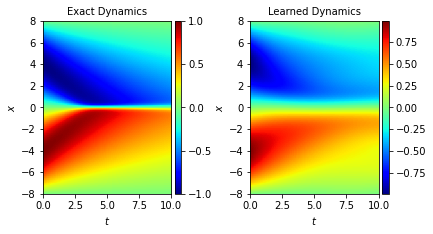

In [ ]:
# t_sol_star1=  torch.from_numpy(t_sol_star).type(torch.DoubleTensor)
# x_sol_star1= torch.from_numpy(x_sol_star).type(torch.DoubleTensor)
# u_pred = pinn.forward(t_sol_star1, x_sol_star1)
# u_pred = u_pred.detach().numpy()
U_pred = griddata(X_sol_star, u_pred.flatten(), (T_sol, X_sol), method='cubic')

fig, ax = plt.subplots()
ax.axis('off')
    
######## Row 2: Pressure #######################
########      Predicted p(t,x,y)     ########### 
gs = gridspec.GridSpec(1, 2)
gs.update(top=0.8, bottom=0.2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs[:, 0])
h = ax.imshow(Exact_sol, interpolation='nearest', cmap='jet', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Exact Dynamics', fontsize = 10)

########     Exact p(t,x,y)     ########### 
ax = plt.subplot(gs[:, 1])
h = ax.imshow(U_pred, interpolation='nearest', cmap='jet', 
              extent=[lb_sol[0], ub_sol[0], lb_sol[1], ub_sol[1]], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('Learned Dynamics', fontsize = 10)